In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.carbon import calculate_total_carbon
from utils.cost import calculate_total_cost

# Preprocess Data

In [2]:
# INPUTS
TIME_HORIZONS= [2020,2050,2100]

def get_csv_file_path(time_horizon: int) -> str:
    file_name =f"{time_horizon}_merged_simulation_results.csv"
    return f"inputs/{file_name}"

In [3]:
# COLUMN LABELS
TIME_HORIZON_LABEL = "time_horizon"
SIMULATION_ID = "simulation_id"
WINDOWS_U_FACTOR = 'windows_U_Factor'
GROUND_FLOOR_THERMAL_RESISTANCE = "groundfloor_thermal_resistance"
EXT_WALLS_THERMAL_RESISTANCE = "ext_walls_thermal_resistance"
ROOF_THERMAL_RESISTANCE= "roof_thermal_resistance"
ANNUAL_ENERGY_CONSUMPTION = "annual_energy_consumption"
TOTAL_COST = "total_cost"
TOTAL_CARBON_EMISSION = "total_carbon_emission"
COMFORT_DAYS = "comfort_days"

ELECTRICITY_BUILDING = "Electricity:Building"
ELECTRICITY_FACILITY = "Electricity:Facility"
GAS_CONSUMPTION = "Gas Consumption"
INDOOR_TEMPERATURE = "Zone Mean Air Temperature"

In [4]:

# Initialize the dataframe with the inputs
df_inputs = pd.DataFrame()
df_inputs = pd.DataFrame(columns=[SIMULATION_ID, TIME_HORIZON_LABEL, WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE])

# Initialize the dataframe with the outputs
df_outputs = pd.DataFrame()
df_outputs = pd.DataFrame(columns=[SIMULATION_ID, ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS])

for time_horizon in TIME_HORIZONS:
    df = pd.read_csv(get_csv_file_path(time_horizon=time_horizon))

    date_columns = [col for col in df.columns if col.startswith(f"{str(time_horizon)}-")]

    for simulation_id, group in df.groupby('Simulation ID'):

        # Inputs
        df_inputs = pd.concat([df_inputs,
            pd.DataFrame({
                SIMULATION_ID: [int(simulation_id)],
                TIME_HORIZON_LABEL: [time_horizon],
                WINDOWS_U_FACTOR : [group[WINDOWS_U_FACTOR].iloc[0]],
                GROUND_FLOOR_THERMAL_RESISTANCE:[group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]],
                EXT_WALLS_THERMAL_RESISTANCE:[group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]],
                ROOF_THERMAL_RESISTANCE: [group[ROOF_THERMAL_RESISTANCE].iloc[0]]
            })], ignore_index=True
        )



        # Extract values
        electricity_building = group[group['index'].str.contains(ELECTRICITY_BUILDING)].iloc[0]
        electricity_facility = group[group['index'].str.contains(ELECTRICITY_FACILITY)].iloc[0] 
        gas_consumption = group[group['index'].str.contains(GAS_CONSUMPTION)].iloc[0] 
        indoor_temperature=group[group['index'].str.contains(INDOOR_TEMPERATURE)].iloc[0]


        annual_energy_consumption = (electricity_building[date_columns].sum() + 
                                electricity_facility[date_columns].sum() + 
                                gas_consumption[date_columns].sum())/10**9
        

        window_U_factor= group[WINDOWS_U_FACTOR].iloc[0]
        groundfloor_thermal_resistance=group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]
        ext_walls_thermal_resistance=group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]
        roof_thermal_resistance=group[ROOF_THERMAL_RESISTANCE].iloc[0]

        total_cost = calculate_total_cost(
            window_U_Factor=window_U_factor, 
            groundfloor_thermal_resistance=groundfloor_thermal_resistance,
            ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
            roof_thermal_resistance=roof_thermal_resistance
            )
        
        comfort_days = min(len([item for item in indoor_temperature[date_columns].values if 18<item<24]),365)
        
        total_carbon_emission = calculate_total_carbon(        
            window_U_Factor=window_U_factor, 
            groundfloor_thermal_resistance=groundfloor_thermal_resistance,
            ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
            roof_thermal_resistance=roof_thermal_resistance
            )
        

        df_outputs = pd.concat([df_outputs,
            pd.DataFrame({
                SIMULATION_ID: [int(simulation_id)],
                ANNUAL_ENERGY_CONSUMPTION : [annual_energy_consumption],
                TOTAL_COST: [total_cost],
                TOTAL_CARBON_EMISSION: [total_carbon_emission],
                COMFORT_DAYS: [comfort_days]
            })], ignore_index=True
        )

In [5]:
df_outputs

,simulation_id,annual_energy_consumption,total_cost,total_carbon_emission,comfort_days
0,1,4814.452339,0,0,233
1,2,4612.654118,182,9.36,246
2,3,4616.508510,179,4.83,248
3,4,4597.365174,200,17.16,244
4,5,4608.445220,222,8.5,244
...,...,...,...,...,...
1868,621,3383.527300,869,137.68,276
1869,622,3225.893625,1051,147.04,287
1870,623,3223.021424,1048,142.51,289
1871,624,3207.971091,1069,154.84,292


In [6]:
df_inputs

,simulation_id,time_horizon,windows_U_Factor,groundfloor_thermal_resistance,ext_walls_thermal_resistance,roof_thermal_resistance
0,1,2020,2.90,0.41,0.45,0.48
1,2,2020,2.90,0.41,4.00,0.48
2,3,2020,2.90,0.41,4.01,0.48
3,4,2020,2.90,0.41,6.67,0.48
4,5,2020,2.90,0.41,6.68,0.48
...,...,...,...,...,...,...
1868,621,2100,0.81,5.57,0.45,8.34
1869,622,2100,0.81,5.57,4.00,8.34
1870,623,2100,0.81,5.57,4.01,8.34
1871,624,2100,0.81,5.57,6.67,8.34


# Load and Preprocess data


In [7]:
X_data = df_inputs[[TIME_HORIZON_LABEL, WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE]].values
Y_data = df_outputs[[ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS]].values
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
# Normalize the data 
X_data_normalized = scaler_X.fit_transform(X_data)
Y_data_normalized = scaler_Y.fit_transform(Y_data)

# Y_ORIGINAL = scaler_Y.inverse_transform(Y_data_normalized)


# Split the dataset into training, testing and validation sets
# Split data into train, validation, and test sets
# Training Set: 70% of the original data.
# Validation Set: 15% of the original data (from the temporary set).
# Test Set: 15% of the original data (from the temporary set).

train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    X_data_normalized, Y_data_normalized, test_size=0.3, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, temp_outputs, test_size=0.5, random_state=42
)

# Convert to torch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs = torch.tensor(val_outputs, dtype=torch.float32)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

Epoch [10/200], Training Loss: 0.6851, Validation Loss: 0.6848
Epoch [20/200], Training Loss: 0.4594, Validation Loss: 0.4630
Epoch [30/200], Training Loss: 0.3549, Validation Loss: 0.3742
Epoch [40/200], Training Loss: 0.3327, Validation Loss: 0.3567
Epoch [50/200], Training Loss: 0.3060, Validation Loss: 0.3353
Epoch [60/200], Training Loss: 0.2892, Validation Loss: 0.3232
Epoch [70/200], Training Loss: 0.2736, Validation Loss: 0.3096
Epoch [80/200], Training Loss: 0.2613, Validation Loss: 0.2984
Epoch [90/200], Training Loss: 0.2513, Validation Loss: 0.2900
Epoch [100/200], Training Loss: 0.2435, Validation Loss: 0.2837
Epoch [110/200], Training Loss: 0.2375, Validation Loss: 0.2787
Epoch [120/200], Training Loss: 0.2330, Validation Loss: 0.2754
Epoch [130/200], Training Loss: 0.2297, Validation Loss: 0.2727
Epoch [140/200], Training Loss: 0.2270, Validation Loss: 0.2707
Epoch [150/200], Training Loss: 0.2247, Validation Loss: 0.2691
Epoch [160/200], Training Loss: 0.2228, Validatio

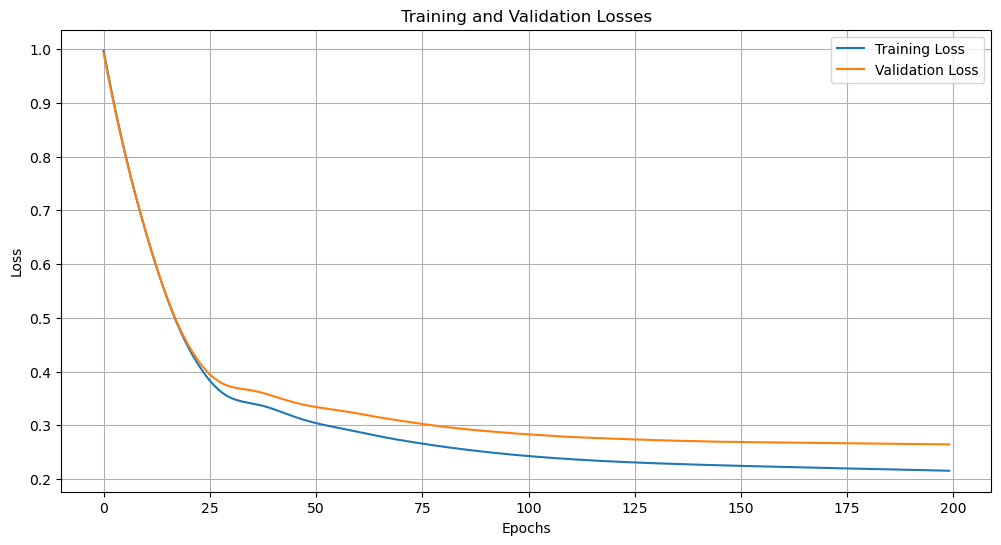

In [ ]:
# class MultiTaskModel(nn.Module):
#     def __init__(self):
#         super(MultiTaskModel, self).__init__()
#         self.fc1 = nn.Linear(5, 128) # Shared layers
#         self.fc2 = nn.Linear(128, 64) # Shared Layer

        # Define standard MLP for energy-specific layers
        # self.fc3_energy = nn.Sequential(
        #     nn.Linear(64, 32),    # First hidden layer of the MLP
        #     nn.ReLU(),            # Activation function
        #     nn.Linear(32, 16),    # Second hidden layer of the MLP
        #     nn.ReLU(),            # Activation function
        #     nn.Linear(16, 1)      # Output layer for energy consumption
        # )

        # define deep MLP for cost-specific layers
        # self.fc3_cost = nn.Sequential(
        #     nn.Linear(64, 64),    # First hidden layer for cost
        #     nn.ReLU(),            # Activation function
        #     nn.Linear(64, 32),    # Second hidden layer for cost
        #     nn.ReLU(),            # Activation function
        #     nn.Linear(32, 16),    # Third hidden layer for cost
        #     nn.ReLU(),            # Activation function
        #     nn.Linear(16, 1)      # Output layer for total cost
        # )

        # Define regularized MLP for energy specific layers
        # self.fc3_energy = nn.Sequential(
        #     nn.Linear(64, 32),      # First hidden layer
        #     nn.BatchNorm1d(32),     # Batch normalization
        #     nn.ReLU(),              # Activation function
        #     nn.Dropout(0.3),        # Dropout with 30% probability
        #     nn.Linear(32, 16),      # Second hidden layer
        #     nn.BatchNorm1d(16),     # Batch normalization
        #     nn.ReLU(),              # Activation function
        #     nn.Dropout(0.3),        # Dropout with 30% probability
        #     nn.Linear(16, 1)        # Output layer for energy consumption
        # )

        

#         self.fc3_energy = nn.Linear(64, 1)  # Annual Energy Consumption
#         self.fc3_cost = nn.Linear(64, 1)    # Total Cost
#         self.fc3_emission = nn.Linear(64, 1) # Total Carbon Emission
#         self.fc3_comfort = nn.Linear(64, 1)  # Comfort Days



#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         energy = self.fc3_energy(x)
#         cost = self.fc3_cost(x)
#         emission = self.fc3_emission(x)
#         comfort = self.fc3_comfort(x)
#         return energy, cost, emission, comfort

# # Instantiate the model, define the loss function and the optimizer
# model = MultiTaskModel()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Task-specific Weights
# task_weights = [0.4, 0.3, 0.2, 0.1]  # Weights for energy, cost, emission, comfort, respectively

# # Training the model
# num_epochs = 200
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     outputs = model(train_inputs)
#     loss = sum(task_weights[i] * criterion(outputs[i], train_outputs[:, i:i+1]) for i in range(4))  # Total loss for all tasks
#     loss.backward()
#     optimizer.step()

#     train_losses.append(loss.item())

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs_pred = model(val_inputs)
#         val_loss = sum(task_weights[i] * criterion(val_outputs_pred[i], val_outputs[:, i:i+1]) for i in range(4))
#         val_losses.append(val_loss.item())

#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# # Plotting training and validation losses
# plt.figure(figsize=(12, 6))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Training and Validation Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()



Epoch [10/200], Total Training Loss: 3.7940, Validation Loss: 3.8965
Epoch [20/200], Total Training Loss: 3.1850, Validation Loss: 3.3134
Epoch [30/200], Total Training Loss: 2.7084, Validation Loss: 2.8194
Epoch [40/200], Total Training Loss: 2.2878, Validation Loss: 2.4821
Epoch [50/200], Total Training Loss: 2.0636, Validation Loss: 2.2757
Epoch [60/200], Total Training Loss: 1.8918, Validation Loss: 2.1218
Epoch [70/200], Total Training Loss: 1.7701, Validation Loss: 2.0106
Epoch [80/200], Total Training Loss: 1.6876, Validation Loss: 1.9283
Epoch [90/200], Total Training Loss: 1.6411, Validation Loss: 1.8845
Epoch [100/200], Total Training Loss: 1.6090, Validation Loss: 1.8547
Epoch [110/200], Total Training Loss: 1.5811, Validation Loss: 1.8353
Epoch [120/200], Total Training Loss: 1.5551, Validation Loss: 1.8169
Epoch [130/200], Total Training Loss: 1.5291, Validation Loss: 1.7968
Epoch [140/200], Total Training Loss: 1.5033, Validation Loss: 1.7784
Epoch [150/200], Total Traini

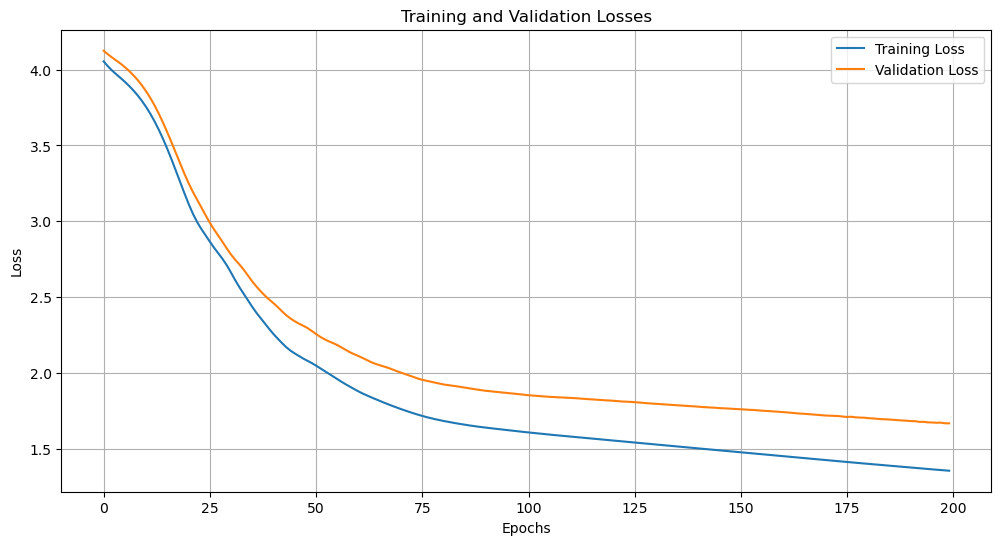

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # Shared layers
        self.fc2 = nn.Linear(128, 64)  # Shared Layer

        # Energy-specific layers
        self.energy_fc1 = nn.Linear(64, 3)  # First energy-specific hidden layer
        self.energy_fc2 = nn.Linear(3, 3)   # Second energy-specific hidden layer
        self.fc3_energy = nn.Linear(3, 1)   # Output layer for Annual Energy Consumption

        # Cost-specific layers
        self.cost_fc1 = nn.Linear(64, 100)  # First cost-specific hidden layer
        self.cost_fc2 = nn.Linear(100, 64)  # Second cost-specific hidden layer
        self.fc3_cost = nn.Linear(64, 1)    # Output layer for Total Cost

        # Emission-specific layers
        self.emission_fc1 = nn.Linear(64, 14)  # First carbon-specific hidden layer
        self.emission_fc2 = nn.Linear(14, 10)  # Second carbon-specific hidden layer
        self.fc3_emission = nn.Linear(10, 1)   # Output layer for Carbon Emission

        # Comfort-specific layers
        self.comfort_fc1 = nn.Linear(64, 6)  # Hidden layer for Comfort
        self.fc3_comfort = nn.Linear(6, 1)   # Output layer for Comfort Days

#        self.fc3_energy = nn.Linear(64, 1)  # Annual Energy Consumption
#        self.fc3_cost = nn.Linear(64, 1)    # Total Cost
#        self.fc3_emission = nn.Linear(64, 1)  # Total Carbon Emission
#        self.fc3_comfort = nn.Linear(64, 1)  # Comfort Days

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Energy-specific pathway
        energy = torch.relu(self.energy_fc1(x))
        energy = torch.relu(self.energy_fc2(energy))
        energy = self.fc3_energy(energy)

        # Cost-specific pathway
        cost = torch.relu(self.cost_fc1(x))
        cost = torch.relu(self.cost_fc2(cost))
        cost = self.fc3_cost(cost)

        # Emission specific pathway
        emission = torch.relu(self.emission_fc1(x))
        emission = torch.relu(self.emission_fc2(emission))
        emission = self.fc3_emission(emission)

        # Comfort specific pathway
        comfort = torch.relu(self.comfort_fc1(x))
        comfort = self.fc3_comfort(comfort)

#        energy = self.fc3_energy(x)
#        cost = self.fc3_cost(x)
#        emission = self.fc3_emission(x)
#        comfort = self.fc3_comfort(x)
        return energy, cost, emission, comfort

# Instantiate the model
model = MultiTaskModel()

# Define separate loss functions for each task
loss_functions = {
    'energy': nn.MSELoss(),
    'cost': nn.MSELoss(),
    'emission': nn.MSELoss(),
    'comfort': nn.MSELoss()
}

# Define separate optimizers for each task-specific layer and shared layers
optimizer_shared = optim.Adam([{'params': model.fc1.parameters()},
                               {'params': model.fc2.parameters()}], lr=0.001)

optimizer_energy = optim.Adam([{'params': model.energy_fc1.parameters()},
                               {'params': model.energy_fc2.parameters()},
                               {'params': model.fc3_energy.parameters()}], lr=0.001)

optimizer_cost = optim.Adam([{'params': model.cost_fc1.parameters()},
                             {'params': model.cost_fc2.parameters()},
                             {'params': model.fc3_cost.parameters()}], lr=0.001)

optimizer_emission = optim.Adam([{'params': model.emission_fc1.parameters()},
                                 {'params': model.emission_fc2.parameters()},
                                 {'params': model.fc3_emission.parameters()}], lr=0.001)

optimizer_comfort = optim.Adam([{'params': model.comfort_fc1.parameters()},
                                {'params': model.fc3_comfort.parameters()}], lr=0.001)


# optimizer_energy = optim.Adam(model.fc3_energy.parameters(), lr=0.001)
# optimizer_cost = optim.Adam(model.fc3_cost.parameters(), lr=0.001)
# optimizer_emission = optim.Adam(model.fc3_emission.parameters(), lr=0.001)
#optimizer_comfort = optim.Adam(model.fc3_comfort.parameters(), lr=0.001)

# Training the model
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer_shared.zero_grad()
    optimizer_energy.zero_grad()
    optimizer_cost.zero_grad()
    optimizer_emission.zero_grad()
    optimizer_comfort.zero_grad()

    # Forward pass
    energy, cost, emission, comfort = model(train_inputs)

    # Compute separate losses
    loss_energy = loss_functions['energy'](energy, train_outputs[:, 0:1])
    loss_cost = loss_functions['cost'](cost, train_outputs[:, 1:2])
    loss_emission = loss_functions['emission'](emission, train_outputs[:, 2:3])
    loss_comfort = loss_functions['comfort'](comfort, train_outputs[:, 3:4])

    # Perform backward pass and optimizer steps for each task
    loss_energy.backward(retain_graph=True)
    optimizer_energy.step()

    loss_cost.backward(retain_graph=True)
    optimizer_cost.step()

    loss_emission.backward(retain_graph=True)
    optimizer_emission.step()

    loss_comfort.backward(retain_graph=True)
    optimizer_comfort.step()

    # Also update shared parameters
    optimizer_shared.step()

    # Log total loss
    total_loss = loss_energy.item() + loss_cost.item() + loss_emission.item() + loss_comfort.item()
    train_losses.append(total_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_energy, val_cost, val_emission, val_comfort = model(val_inputs)
        val_loss_energy = loss_functions['energy'](val_energy, val_outputs[:, 0:1])
        val_loss_cost = loss_functions['cost'](val_cost, val_outputs[:, 1:2])
        val_loss_emission = loss_functions['emission'](val_emission, val_outputs[:, 2:3])
        val_loss_comfort = loss_functions['comfort'](val_comfort, val_outputs[:, 3:4])
        
        # Aggregate validation losses
        val_loss = val_loss_energy + val_loss_cost + val_loss_emission + val_loss_comfort
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Total Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
# Testing the model
model.eval()
with torch.no_grad():
    test_outputs_pred = model(test_inputs)

# Inverse transform to get original scale
Y_test_inverse = scaler_Y.inverse_transform(test_outputs.numpy())
Y_test_pred_inverse = scaler_Y.inverse_transform(torch.cat(test_outputs_pred, dim=1).numpy())

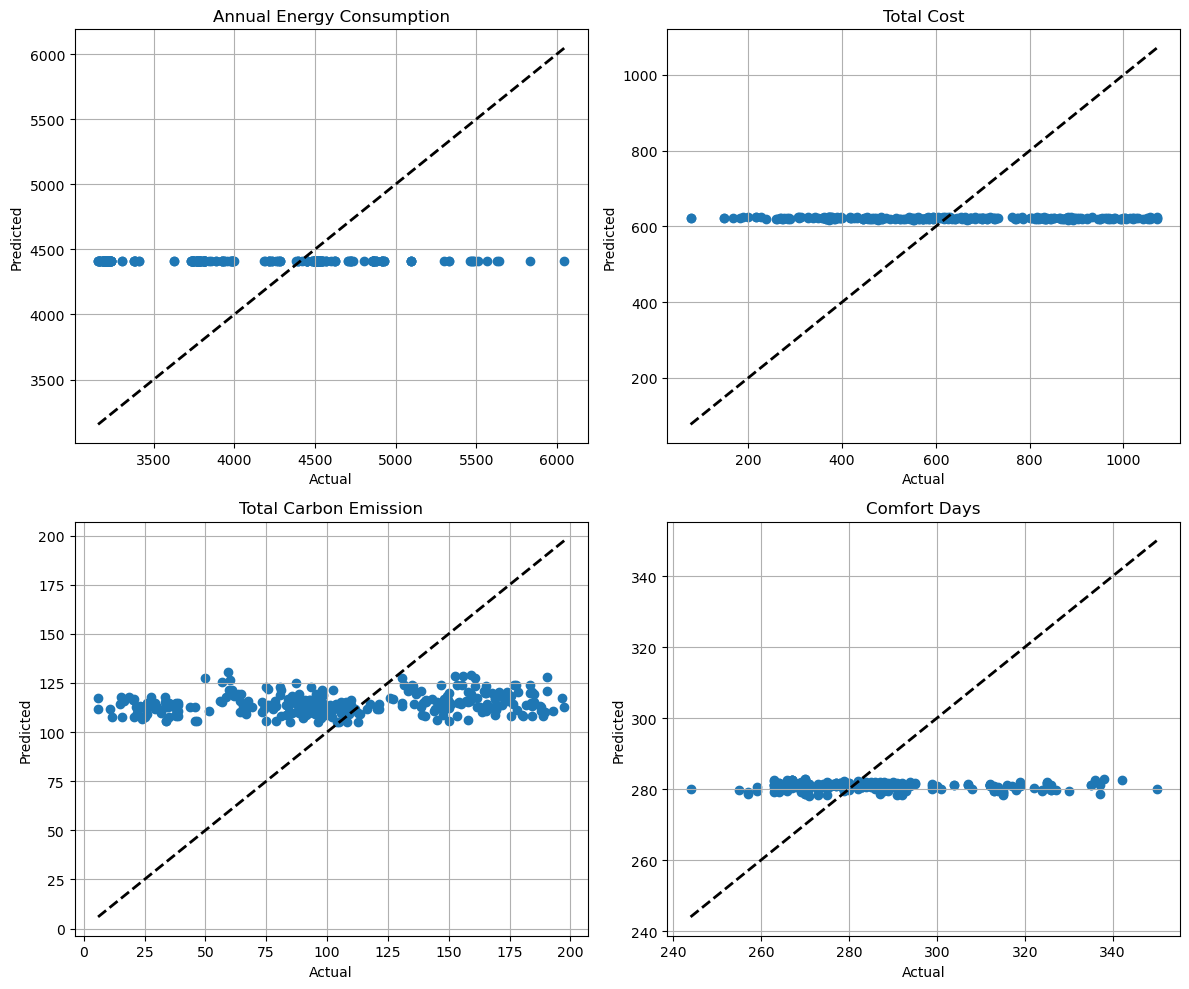

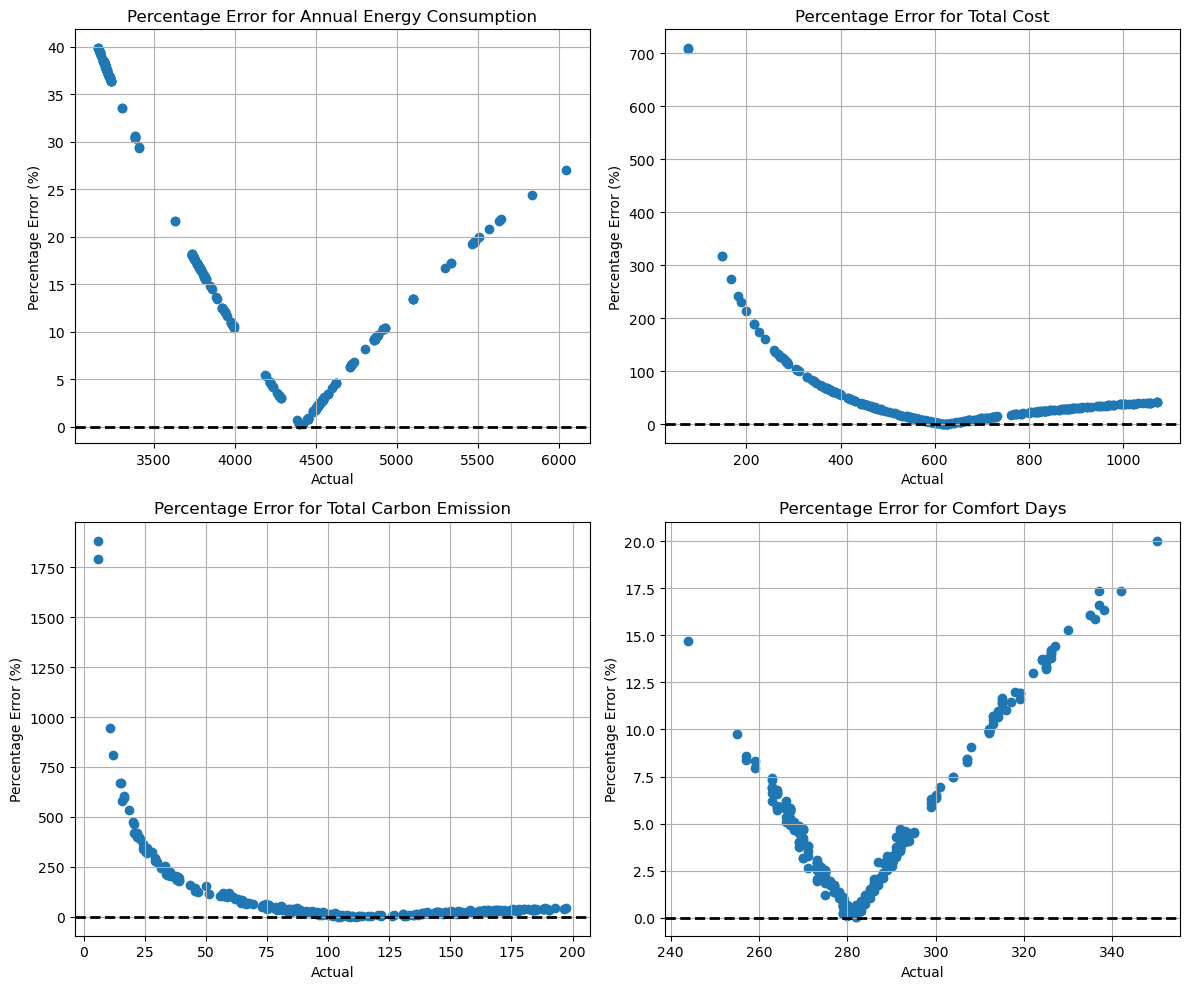

In [17]:
# Calculate percentage error
percentage_error = np.abs((Y_test_pred_inverse - Y_test_inverse) / Y_test_inverse) * 100

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define labels for outputs
outputs_labels = ['Annual Energy Consumption', 'Total Cost', 'Total Carbon Emission', 'Comfort Days']

# Predicted vs Actual scatter plots
for i in range(4):
    axs[i // 2, i % 2].scatter(Y_test_inverse[:, i], Y_test_pred_inverse[:, i])
    axs[i // 2, i % 2].plot([Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()],
                             [Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()], 'k--', lw=2)
    axs[i // 2, i % 2].set_title(outputs_labels[i])
    axs[i // 2, i % 2].set_xlabel('Actual')
    axs[i // 2, i % 2].set_ylabel('Predicted')
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

# Plotting percentage error
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(4):
    axs[i // 2, i % 2].scatter(Y_test_inverse[:, i], percentage_error[:, i])
    axs[i // 2, i % 2].axhline(y=0, color='k', linestyle='--', lw=2)  # Line for 0% error
    axs[i // 2, i % 2].set_title(f'Percentage Error for {outputs_labels[i]}')
    axs[i // 2, i % 2].set_xlabel('Actual')
    axs[i // 2, i % 2].set_ylabel('Percentage Error (%)')
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

In [29]:
percentage_error

array([[10.546795 , 23.250547 , 22.15635  ,  4.838767 ],
       [15.735348 , 39.696053 , 24.16731  ,  0.8475683],
       [ 4.606438 , 30.331257 , 21.649382 , 14.081521 ],
       ...,
       [ 2.006624 , 11.318826 , 30.6603   ,  5.800066 ],
       [12.514737 ,  1.4215038,  1.2762289,  9.916296 ],
       [36.864887 ,  7.744235 , 41.855938 ,  2.3860612]], dtype=float32)

# Optimization Algorithm

In [ ]:
import numpy as np
import torch
from scipy.optimize import differential_evolution
from torch import nn



# Define a function to make predictions with the MTL model
def model(params):
    input_tensor = torch.tensor(params, dtype=torch.float32)
    energy, cost, emission, comfort = model(input_tensor)
    return float(energy), float(cost), float(emission), float(comfort)

# Define the objective function with constraints, including time horizon constraint
def objective_function(params):
    energy, cost, emission, comfort = model(params)
    time_horizon = params[4]  # Last parameter is the time horizon
    # Add constraints including the fixed time horizon of 2050
    if not (4000 <= energy <= 5000 and comfort >= 100 and 30 <= cost <= 400 and 30 <= emission <= 100 and time_horizon == 2050):
        return 1e6  # penalty for violating constraints
    return energy + cost + emission - comfort * 0.1  # Minimize energy, cost, emission, maximize comfort

# Parameter bounds for optimization [(min, max) for each retrofit parameter]
bounds = [
    (0.3, 8.0),   # Groundfloor Thermal Resistance
    (0.5, 8.0),   # U Factor of Windows
    (0.3, 8.0),  # Roof Thermal Resistance
    (0.3, 8.0),  # Facade Thermal Resistance
    (2050, 2050)  # Time Horizon, fixed at 2050
]

# Perform optimization
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=1000, popsize=15)

# Get optimal parameters and predictions
optimal_params = result.x
optimal_energy, optimal_cost, optimal_emission, optimal_comfort = model(optimal_params)

# Print results
print("Optimal Retrofit Parameters:")
print("Groundfloor Thermal Resistance:", optimal_params[0])
print("U Factor of Windows:", optimal_params[1])
print("Roof Thermal Resistance:", optimal_params[2])
print("Facade Thermal Resistance:", optimal_params[3])
print("Time Horizon:", optimal_params[4])
print("\nPredicted Results for Optimal Retrofit:")
print("Energy Consumption:", optimal_energy)
print("Cost:", optimal_cost)
print("Embodied Carbon:", optimal_emission)
print("Comfort Days:", optimal_comfort)


In [ ]:
from scipy.optimize import NonlinearConstraint

def mtl_model(params):
    with torch.no_grad():
        input_tensor = torch.tensor(params, dtype=torch.float32).unsqueeze(0)
        energy, cost, emission, comfort = model(input_tensor)
        return energy.item(), cost.item(), emission.item(), comfort.item()

def constraint_func(params):
    energy, cost, emission, comfort = mtl_model(params)
    return [
        energy,
        5000 - energy,
        comfort,  # max energy constraint
        350 - comfort,
        cost,
        400 - cost,     # max cost constraint
        emission,
        100 - emission  # max emission constraint
    ]

# Define the nonlinear constraints
nonlinear_constraints = NonlinearConstraint(constraint_func, 0, np.inf)

bounds = [
    (0.3, 3.0),   # Groundfloor Thermal Resistance
    (0.5, 3.0),   # U Factor of Windows
    (0.3, 3.0),   # Roof Thermal Resistance
    (0.3, 3.0),   # Facade Thermal Resistance
    (2100, 2100)  # Time Horizon
]

result = differential_evolution(
    objective_function, bounds, constraints=[nonlinear_constraints],
    strategy='best1bin', maxiter=1000, popsize=15
)

optimal_params = result.x
optimal_energy, optimal_cost, optimal_emission, optimal_comfort = mtl_model(optimal_params)

print("Optimal Retrofit Parameters:")
print(f"Groundfloor Thermal Resistance: {optimal_params[0]}")
print(f"U Factor of Windows: {optimal_params[1]}")
print(f"Roof Thermal Resistance: {optimal_params[2]}")
print(f"Facade Thermal Resistance: {optimal_params[3]}")
print(f"Time Horizon: {optimal_params[4]}")
print("\nPredicted Results for Optimal Retrofit:")
print(f"Energy Consumption: {optimal_energy}")
print(f"Cost: {optimal_cost}")
print(f"Embodied Carbon: {optimal_emission}")
print(f"Comfort Days: {optimal_comfort}")




Optimal Retrofit Parameters:
Groundfloor Thermal Resistance: 2.4990683870360484
U Factor of Windows: 2.9362991146511117
Roof Thermal Resistance: 0.8062616119085375
Facade Thermal Resistance: 2.8459763503263207
Time Horizon: 2100.0

Predicted Results for Optimal Retrofit:
Energy Consumption: 64.69245147705078
Cost: -137.82467651367188
Embodied Carbon: -25.201507568359375
Comfort Days: 83.0357894897461
